# Resnet18


In [1]:
# imports
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import glob

# transformers
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean

# dataset imports
import os
import torch
import torch.utils.data
import torchvision
import torch
import torch.nn as nn

# model imports
import copy

# evaluation imports
import time
from sklearn import metrics

In [2]:
# model 
model = torchvision.models.resnet18()

In [31]:
# altering model for 4 channel input and 19 out features
model.conv1 = nn.Conv2d(4, 64, (7, 7), 
                        stride=(2,2), 
                        padding=(3,3), 
                        bias=False)

# output features to 3 classification
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=512,
        out_features=19
    ),
    torch.nn.Sigmoid()
)

In [32]:
model

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Loading Dataframe

In [9]:
df = pd.read_csv('../input/train.csv')
# Transform string label to 19 one-hot columns
cols = [str(i) for i in list(range(19))]
df[cols] = np.nan

# Apply mapping
def encoder(row):
    labels = row['Label'].split('|')
    for label in labels:
        row[label] = 1    
    return row

df = df.apply(encoder, axis=1)
df.fillna(0, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21806 entries, 0 to 21805
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      21806 non-null  object 
 1   Label   21806 non-null  object 
 2   0       21806 non-null  float64
 3   1       21806 non-null  float64
 4   2       21806 non-null  float64
 5   3       21806 non-null  float64
 6   4       21806 non-null  float64
 7   5       21806 non-null  float64
 8   6       21806 non-null  float64
 9   7       21806 non-null  float64
 10  8       21806 non-null  float64
 11  9       21806 non-null  float64
 12  10      21806 non-null  float64
 13  11      21806 non-null  float64
 14  12      21806 non-null  float64
 15  13      21806 non-null  float64
 16  14      21806 non-null  float64
 17  15      21806 non-null  float64
 18  16      21806 non-null  float64
 19  17      21806 non-null  float64
 20  18      21806 non-null  float64
dtypes: float64(19), object(2)
memory us

## Transformations

In [11]:
class Tile(object):
    """
    Takes in:
    imgs = {
            'red': Image.open(r_path),
            'green': Image.open(g_path),
            'blue': Image.open(b_path),
            'yellow': Image.open(y_path),
            'mask': Image.open(mask_path)
        }
    
    target = {
        'image_id': torch.tensor([idx]),
        'labels': np.array(df.iloc[idx, 3:])
    }
    Outputs:
    
    imgs = {
            'tiles': tiles
        }
        
    target = {
        'image_id': torch.tensor([idx]),
        'labels': np.array(df.iloc[idx, 3:])
    }
    """
    @staticmethod
    def tiled_img(r, g, b, y, box):
        """
        Find center of box. Crop the image using PIL
        at center, using desired tile size.
        """
        # (xmax-xmin) / 2 , (ymax - ymin) /2
        center = ( (box[2]-box[0])/2, (box[3]-box[1])/2 )
        left = box[0]
        top = box[1]
        right = box[2]
        bottom = box[3]
        
        # crop channels
        r = r.crop((left, top, right, bottom))
        g = g.crop((left, top, right, bottom))
        b = b.crop((left, top, right, bottom))
        y = y.crop((left, top, right, bottom))
        
        # return cropped channels using PIL 
        rgby = np.dstack((r,g,b,y))
    
        return(rgby)
    
    
    @staticmethod
    def split_mask(mask):
        # convert to array for individual segments
        mask = np.array(mask)
        # split into different segmentations
        obj_ids = np.unique(mask)
        # 0 is background, get rid
        obj_ids = obj_ids[1:]
        
        # split color-encoded mask into
        # a set of binary masks
        
        masks = mask == obj_ids[:, None, None] # HOW DOES THIS WORK
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        return boxes
        
        
    @staticmethod
    def gen_labels(labels, num_objs):
        """
        Take in numpy array of one hot encoded labels
        output:
        [N, OHE labels]
        where N is the number of objects or tiles
        """
        return [labels for i in range(num_objs)]
        
        
    def __call__(self, sample):
        imgs, target = sample
        
        # get masks
        boxes = self.split_mask(imgs['mask'])
         
        # list of tiled imgs
        tiles = list()
        for box in boxes:
            tiles.append(self.tiled_img(imgs['red'],
                                        imgs['green'],
                                        imgs['blue'],
                                        imgs['yellow'],
                                        box))
            
        # target
        new_target = {
        'image_id': target['image_id'],
        'labels': self.gen_labels(target['labels'], len(boxes))
        }
        
        
        return ((tiles, new_target))

In [12]:
class Rescale(object):
    """
    Rescale the tiles received.
    Return rescaled 4 channel images (numpy)
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # check output size is 
                                                     # right format
        self.output_size = output_size

    def __call__(self, sample):
        
        imgs, target = sample
        for i in range(len(imgs)):
            # numpy.shape responds with (H, W, C)
            h = imgs[i].shape[0] 
            w = imgs[i].shape[1] 

            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            #resize iamge
            imgs[i] = resize(imgs[i], 
                             (new_h, new_w))
        return ((imgs, target))

In [13]:
class ImageToTensor(object):
    """
    Custom to tensor class, does not accept dictionary.
    """

    @staticmethod
    def image_tensor(imgs):
        return [torch.from_numpy(im).permute(2,0,1) for im in imgs]
    
    
    @staticmethod
    def idx_tensor(idx):
        return torch.tensor(idx)
    
    
    @staticmethod
    def labels_tensor(labels):
        return[torch.from_numpy(l) for l in labels]
    
    
    def __call__(self, sample):
        imgs, target = sample
        # torch image: C X H X W
        t_tiles = self.image_tensor(imgs)
        idx = self.idx_tensor(target['image_id'])
        labels = self.labels_tensor(target['labels'])
        
        new_target = {
            'image_id': idx,
            'labels': labels
        }
        return ((t_tiles, new_target))

In [14]:
# define transforms
def get_transform():
    custom_transforms = [Tile(), Rescale((224,224)), 
                         ImageToTensor()]
    return torchvision.transforms.Compose(custom_transforms)

## Dataset

In [15]:
class HPAImageDataset(object):
    
    
    def __init__(self, root, transforms, df):
        self.root = root
        self.df = df
        self.transforms = transforms
 

    def __len__(self):
        return(len(self.df))
                          
    
    def __getitem__(self, idx):
        # load channels and masks for idx
        r_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_red.png')
        g_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_green.png')
        b_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_blue.png')
        y_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_yellow.png')
        
        mask_path = os.path.join(self.root, 
                                 "mask", 
                                 self.df.ID[idx]+'_predictedmask.png')

        # open imgs in PIL
        imgs = {
            'red': Image.open(r_path),
            'green': Image.open(g_path),
            'blue': Image.open(b_path),
            'yellow': Image.open(y_path),
            'mask': Image.open(mask_path)
        }
    
        #define target
        target = {
            'image_id': idx,
            'labels': self.df.iloc[0, 2:].to_numpy(dtype='float16')
        }
        
        if self.transforms is not None:
            # torchvision compose only accepts single input
            sample = self.transforms((imgs, target))
            imgs, target = sample
        # return((imgs, target))  if we want to include imge ID
        return((imgs, target['labels']))

In [16]:
ROOT_DIR = '../input/image_subset/'

# create own Dataset
transformed_dataset = HPAImageDataset(root=ROOT_DIR,
                          transforms=get_transform(),
                          df=df,
                          )

In [17]:
# single tiled output
transformed_dataset[0][0][0].shape

torch.Size([4, 224, 224])

In [18]:
# number of cols
transformed_dataset[0][1][0].shape

torch.Size([19])

## Dataloader

In [19]:
def collate_fn(batch):
    anno = []
    tiles = []
    for b in batch:
        for label in b[1]:
            anno.append(label)
        for tile in b[0]:
            tiles.append(tile)
    return tuple(zip(tiles, anno))

# set train val split

"""
Stratified K Folding would be better.
"""
# how much of the dataset do you want to train on
subset_dataset = torch.utils.data.Subset(transformed_dataset, 
                                        list(range(0, 1000)))
split = int(0.8 * len(subset_dataset))

# batch size
batch_s = 1

# train dataset & dataloader
dataset_train = torch.utils.data.Subset(subset_dataset, 
                                        list(range(0,split)))

train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_s,
                                          shuffle=True, collate_fn=collate_fn)

# test dataset & dataloader
dataset_test = torch.utils.data.Subset(subset_dataset,
                                     list(range(split, len(subset_dataset))))
test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=1,
                                          shuffle=False, collate_fn=collate_fn)
print(len(dataset_train))
print(len(dataset_test))

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

800
200


This Image has label: tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)


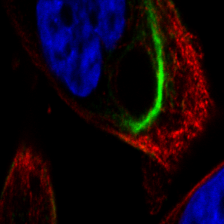

In [23]:
single_batch = next(iter(train_loader))
print('This Image has label: {}'.format(single_batch[0][1]))
# sigle_batch[img ro label][img_n][tile_n]
(transforms.ToPILImage(mode='RGB')(single_batch[0][0][:3, :, :]))

## Training

In [24]:
if len(train_loader) * batch_s == len(dataset_train):
    print('Setup is correct')

Setup is correct


In [27]:
def train_loop(dataloader, model, loss_fn, optimizer, USE_GPU=False):
    """
    Training loop
    """
    # send model to gpu
    if USE_GPU:
        model = model.cuda()
    # get length of dataset
    size = len(dataloader.dataset)
    # set model for training
    model.train()
    
    # counters and logs
    sample_count = 0
    
    # go through batches
    for j, batch in enumerate(dataloader):
        for k in range(len(batch)):           
            # [N, C, W, H]
            X = batch[k][0].unsqueeze(0).float() # model requires tensor stack
            # [N, 19]
            y = torch.reshape(batch[k][1], (1,19))
            
            # send to cuda for gpu training
            if USE_GPU:
                X = X.cuda()
                y = y.cuda()
            
            with torch.set_grad_enabled(True):
                # compute predictions and loss
                pred = model(X)
                loss = loss_fn(pred, y.float())

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            # increment number of samples, only 1 at a time
            sample_count+=1
            
        if j%100 == 0:
            loss, current = loss.item(), j
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [28]:
def test_loop(dataloader, model, loss_fn, threshold=0.5, USE_GPU=False):
    """
    Testing loop   
    """
    # send model to gpu
    if USE_GPU:
        model = model.cuda()
        
    # for testing only 
    model.eval()
    
    # counting and stats
    size = len(dataloader.dataset)
    test_loss, correct, sample_count = 0, 0, 0
    
    with torch.no_grad():
        for batch in dataloader:
            for k in range(len(batch)):
                
                if sample_count == 5:
                    break
                # [N, C, W, H]
                X = batch[k][0].unsqueeze(0).float()
                # [N, 19]
                y = torch.reshape(batch[k][1], (1,19))        
                if USE_GPU:
                    X = X.cuda()
                    y = y.cuda()
                    
                # stats
                sample_count += 1 # 1 sample per k
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += torch.sum((pred >= threshold).float() == y.float()).item()
                
                
    test_loss /= sample_count
    correct /= (sample_count*19)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return(test_loss, correct)

In [33]:
# Config
save = False
USE_GPU = True
EPOCHS = 1
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()
epochs = 1

# weight initiliaze
def initialize_weights(m):
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
              nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data)
          nn.init.constant_(m.bias.data, 0)

model.apply(initialize_weights)
best_acc = 0.0

# save model
def save_model(wts):
    """
    Function to save the most accurate model.
    Perhpas improvement on evaluation metric
    """
    best_model_wts = copy.deepcopy(wts)
    torch.save(best_model_wts, "../models/resnet18.pth")
    print("Saving model weights...")
    
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloaders['train'], model, loss_fn, optimizer, USE_GPU=False)
    test_loss, correct = test_loop(dataloaders['test'], model, loss_fn, threshold=0.7, USE_GPU=False)
    
    
    if (correct>best_acc) and (save==True):
        best_acc = correct
        save_model(model.state_dict())
    
print("Done!")

Epoch 1
-------------------------------
loss: 0.647285  [    0/  800]
loss: 0.633167  [  100/  800]
loss: 0.633166  [  200/  800]
loss: 0.633165  [  300/  800]
loss: 0.633165  [  400/  800]
loss: 0.633165  [  500/  800]
loss: 0.633165  [  600/  800]
loss: 0.633165  [  700/  800]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.634277 

Done!
